In [3]:
import pandas

tr = pandas.read_csv('train.csv')
te = pandas.read_csv('test.csv')
prd = pandas.read_csv('pred.csv')
get_dirty = lambda df:df[(df.uid == None) | (df.iid == None) | (df.score == None) | (df.score > 5.0) | (df.score < 1.0)]
print(get_dirty(tr),get_dirty(te),get_dirty(prd))
#输出发现没有脏数据
cut = lambda df:df[['uid','iid','score','review']].drop_duplicates().dropna()
#丢弃重复和nan的数值，只保留前四列
tr =cut(tr)
te = cut(te)
#输出uid和iid的最大值，用于后续代码使用
print(tr[['uid']].max())
print(tr[['iid']].max())

Empty DataFrame
Columns: [uid, iid, score, review, date]
Index: [] Empty DataFrame
Columns: [uid, iid, score, review, date]
Index: [] Empty DataFrame
Columns: [uid, iid, score, review, date]
Index: []
uid    1925
dtype: int64
iid    789
dtype: int64


In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer

word2vec_sentences = []
def review_preprocess(data):
    l = []
    tk = WordPunctTokenizer()
    lm = WordNetLemmatizer()
    punct = ['.',',','?','!','\"']
    for idx,row in data.iterrows():
        words = [w for w in tk.tokenize(row['review']) if w not in stopwords.words('english') and w not in punct]
        s = ''
        for w in words:
            w = lm.lemmatize(w, pos='n')
            w = lm.lemmatize(w, pos='v')
            s += w.lower() + ' '
        l.append(s)
        word2vec_sentences.append(s)
    data['review']=l

review_preprocess(tr)
review_preprocess(te)
review_preprocess(prd)
tr.to_csv('train_processed.csv')
te.to_csv('test_processed.csv')
prd.to_csv('pred_processed.csv')

In [5]:
from gensim.models import Word2Vec

w2v_len = 70
w2v = Word2Vec(word2vec_sentences, sg=1, size=w2v_len,  window=5,  min_count=2)
w2v.save('w2v.model')

In [6]:
import matplotlib.pyplot as plt
review_lengths = []
for s in word2vec_sentences:
    review_lengths.append(len(s.split(' ')))
plt.hist(review_lengths)

(array([2977.,  863.,  317.,  104.,   36.,   19.,    7.,    8.,    5.,
           3.]),
 array([  6. ,  67.1, 128.2, 189.3, 250.4, 311.5, 372.6, 433.7, 494.8,
        555.9, 617. ]),
 <a list of 10 Patch objects>)

(array([116.,   0.,  88.,   0.,   0., 140.,   0., 248.,   0., 521.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

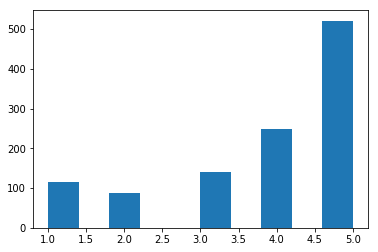

In [7]:
labels = []
for idx,row in te.iterrows():
    labels.append(row['score'])
plt.hist(labels)

In [25]:
import numpy as np
sent_len = 200
def transform(data):
    train_x,train_y = [],[]
    for idx,row in data.iterrows():
        y0 = [0,0,0,0,0]
        y0[int(row['score']-1)] = 1
        y0 = np.array(y0)
        train_y.append(y0)
        wvecs = []
        words = row['review'].split(' ')
        empty_vec = np.array([0 for i in range(w2v_len)])
        if (len(words) > sent_len):
            words = words[:sent_len]
        for w in words:
            if w in w2v:
                wvecs.append(w2v[w])
            else:
                wvecs.append(empty_vec)
        for i in range(sent_len - len(wvecs)):
            wvecs.append(empty_vec)
        wvecs = np.array(wvecs)
        train_x.append(wvecs)
    train_x = np.array(train_x)
    train_y = np.array(train_y)
    return train_x,train_y
train_x,train_y = transform(tr)
test_x,test_y = transform(te)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  app.launch_new_instance()
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Epoch 1/30
1953/1953 [==============================] - 9s 5ms/step - loss: 1.8459 - acc: 0.3917
Epoch 2/30
1953/1953 [==============================] - 7s 4ms/step - loss: 1.5585 - acc: 0.4327A: 0s - loss: 1.5566 - acc: 0.4
Epoch 3/30
1953/1953 [==============================] - 7s 4ms/step - loss: 1.3243 - acc: 0.4967
Epoch 4/30
1953/1953 [==============================] - 7s 4ms/step - loss: 1.1493 - acc: 0.5648
Epoch 5/30
1953/1953 [==============================] - 8s 4ms/step - loss: 1.0020 - acc: 0.6144
Epoch 6/30
1953/1953 [==============================] - 8s 4ms/step - loss: 0.8536 - acc: 0.6841A: 6s - loss: 0.7859 - ac - ETA: 6 - ETA: 4s -
Epoch 7/30
1953/1953 [==============================] - 8s 4ms/step - loss: 0.7536 - acc: 0.7296
Epoch 8/30
1953/1953 [==============================] - 8s 4ms/step - loss: 0.6866 - acc: 0.7465
Epoch 9/30
1953/1953 [==============================] - 8s 4ms/step - loss: 0.7023 - acc: 0.7501A: 0s - loss: 0.7032 - acc: 0
Epoch 10/30
1953/1953

KeyError: 'val_acc'

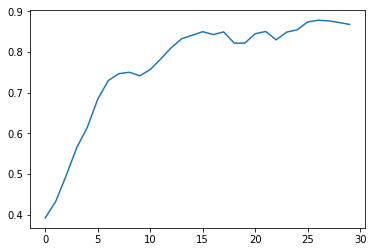

In [129]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers import Conv1D,MaxPooling1D,GlobalAveragePooling1D
from keras.layers.normalization import BatchNormalization

model = Sequential()
model.add(Conv1D(256, 5, padding='same',input_shape = (sent_len,w2v_len)))
model.add(MaxPooling1D(3, 3, padding='same'))
model.add(Conv1D(128, 5, padding='same'))
model.add(MaxPooling1D(3, 3, padding='same'))
model.add(Conv1D(64, 3, padding='same'))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(train_x,train_y,epochs=30, batch_size=16)
import matplotlib.pyplot as plt

# 绘制训练 & 验证的准确率值
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [130]:
model.save('cnn.model')
print(model.metrics_names)
model.evaluate(test_x,test_y,batch_size=16)

['loss', 'acc']
1113/1113 [==============================] - 2s 1ms/step


[2.278462908659984, 0.6477987421651413]

In [152]:
import numpy as np
import random as rd
from collections import defaultdict
from math import sqrt

#基于用户的协同过滤，参数含义在主函数处可见解释
def ucf_pred(m,i2u,u2i,u2m,sim_func,k,ms,uid,iid):
    users = i2u[iid] #评价过物品的所有用户
    if len(users) == 0:
        return ms
    #对于不存在的物品，直接返回所有评分的平均值。实验证明这里若考虑物品不存在用户存在的情况，返回u2m[uid]后RMSE剧增
    mean_all = np.mean([m[suid][iid] for suid in users]) #评价过物品所有用户的均值
    if not uid in u2i:
        return mean_all #用户不存在
    sf = lambda x:sim_func(m,u2i,x,uid)
    if len(users) > k:
        users = sorted(users,key = sf,reverse = 1)[:k] #users大于k时根据相似度重排取相似度最大的几个
    r = u2m[uid] #“普遍”的预测函数
    a,b = 0.0,0.0
    for suid in users:
        a += sf(suid) * (m[suid][iid] - u2m[suid]) 
        b += sf(suid)
    if b == 0:
        return mean_all
    return r + a / b

#直接返回平均值，用作参照
def mean_pred(m,i2u,u2i,u2m,sim_func,k,ms,uid,iid):
    users = i2u[iid]
    if len(users) == 0:
        return ms
    return np.mean([m[suid][iid] for suid in users])

#余弦相似度，同时考虑正例与负例，二者取平均
def cos_sim_prototype(m,u2i,uid1,uid2,cmp):
    assert(uid1 in u2i and uid2 in u2i)
    is1,is2 = u2i[uid1],u2i[uid2]
    pos1,pos2 = set([iid for iid in is1 if cmp(m[uid1][iid],3.0)]),set([iid for iid in is2  if cmp(m[uid2][iid],3.0)])
    overlap = pos1.intersection(pos2)
    b,c = 0.0,0.0
    for iid in pos1:
        b += m[uid1][iid] * m[uid1][iid]
    for iid in pos2:
        c += m[uid2][iid] * m[uid2][iid]
    if b==0 or c==0:
        return 0 #对于分母为0的情况返回0
    return len(overlap) / (sqrt(b) * sqrt(c))

def cos_sim(m,u2i,uid1,uid2):
    return (cos_sim_prototype(m,u2i,uid1,uid2,lambda a,b:a < b) + cos_sim_prototype(m,u2i,uid1,uid2,lambda a,b:a > b)) / 2

#Jaccard相似度，同时考虑正例与负例，二者取平均
def jaccard_sim_prototype(m,u2i,uid1,uid2,cmp):
    assert(uid1 in u2i and uid2 in u2i)
    is1,is2 = u2i[uid1],u2i[uid2]
    pos1,pos2 = set([iid for iid in is1 if cmp(m[uid1][iid],3.0)]),set([iid for iid in is2  if cmp(m[uid2][iid],3.0)])
    a,b = float(len(pos1.intersection(pos2))),len(pos1.union(pos2))
    if b == 0: #对于分母为0的情况返回0
        return 0
    return a / b

def jaccard_sim(m,u2i,uid1,uid2):
    return (jaccard_sim_prototype(m,u2i,uid1,uid2,lambda a,b:a < b) + jaccard_sim_prototype(m,u2i,uid1,uid2,lambda a,b:a > b)) / 2

#皮尔逊相似度
def pearson_sim(m,u2i,uid1,uid2):
    assert(uid1 in u2i and uid2 in u2i)
    is1,is2 = u2i[uid1],u2i[uid2]
    mean1,mean2 = np.mean([m[uid1][iid] for iid in is1]),np.mean([m[uid2][iid] for iid in is2])
    overlap = is1.intersection(is2)
    a,b,c = 0.0,0.0,0.0
    for iid in overlap:
        a += (m[uid1][iid] - mean1) * (m[uid2][iid] - mean2)
        b += (m[uid1][iid] - mean1) * (m[uid1][iid] - mean1)
        c += (m[uid2][iid] - mean2) * (m[uid2][iid] - mean2)
    if b==0 or c==0:
        return -1 #分母为0返回-1
    return a / (sqrt(b) * sqrt(c))

#皮尔逊相似度正则化
def pearson_norm_sim(m,u2i,uid1,uid2):
    return (pearson_sim(m,u2i,uid1,uid2) + 1) / 2

#根据测试集用RMSE进行评估
def evaluate(te,m,i2u,u2i,u2m,sim_func,k,ms,uid,iid,pred_func):
    rmse = 0.0
    n = 0
    for idx,row in te.iterrows():
        uid,iid,score = int(row['uid']),int(row['iid']),row['score']
        n += 1
        p = int(pred_func(m,i2u,u2i,u2m,sim_func,k,ms,uid,iid) + 0.5) #四舍五入
        rmse += (score - p) * (score - p)
    rmse = sqrt(rmse/n)
    return rmse

#初始化 m存储分数矩阵，k为相似用户数，sim_func为相似度函数，i2u为物品-用户倒排表，u2i为用户-物品倒排表,pred_func表示预测函数
m = [[np.nan for j in range(789 + 1)] for i in range (1925 + 1)]
k = 5
sim_func = cos_sim
pred_func = ucf_pred
i2u = defaultdict(set)
u2i = defaultdict(set)

#计算所有评分的平均数ms，用于预测完全未知的用户
n = 0
ms = 0.0
for idx,row in tr.iterrows():
    uid,iid,score = int(row['uid']),int(row['iid']),row['score']
    m[uid][iid] = score
    ms += score
    n += 1
    i2u[iid].add(uid)
    u2i[uid].add(iid)
ms /= n

#u2m存储用户对应的得分平均值
u2m = defaultdict(float)
for uid in u2i:
    u2m[uid]=np.mean([m[uid][iid] for iid in u2i[uid]])

#网格测试，并输出平均对照
'''
mx = 0
v = 999
for i in range(1,21):
    if evaluate(te,m,i2u,u2i,u2m,sim_func,i,ms,uid,iid,pred_func)<v:
        mx,v=i,evaluate(te,m,i2u,u2i,u2m,sim_func,i,ms,uid,iid,pred_func)
print(mx,v)
print(evaluate(te,m,i2u,u2i,u2m,sim_func,k,ms,uid,iid,mean_pred))
'''
'''
#填写答案
ans = []
for idx,row in prd.iterrows():
    uid,iid = int(row['uid']),int(row['iid'])
    ans.append(int(ucf_pred(m,i2u,u2i,u2m,sim_func,k,ms,uid,iid) + 0.5) + 0.0) #四舍五入
prd['score']=ans
prd.to_csv('my_answer.csv')
'''
# mean_pred结果:RMSE=1.284016049251313
# cos_sim的最佳结果:k=5 RMSE=1.1319107397367323
# jaccard_sim的最佳结果k=1 RMSE=1.1323075533298992
# pearson_norm_sim的最佳结果k=3 RMSE=1.2329702483933587
# 由以上网格测试过程可得最佳算法为k=5的cos_sim

linear_train_x = []
linear_train_y = []
i = 0
for idx,row in tr.iterrows():
    x = list(model.predict(np.array([train_x[i]]))[0])
    x.append(ucf_pred(m,i2u,u2i,u2m,sim_func,k,ms,row['uid'],row['iid']))
    linear_train_x.append(x)
    linear_train_y.append(row['score'])
    i += 1
    
linear_test_x = []
linear_test_y = []
i = 0
for idx,row in te.iterrows():
    x = list(model.predict(np.array([train_x[i]]))[0])
    x.append(ucf_pred(m,i2u,u2i,u2m,sim_func,k,ms,row['uid'],row['iid']))
    linear_test_x.append(x)
    linear_test_y.append(row['score'])
    i += 1

In [163]:
from sklearn.linear_model import Ridge
linear_model = Ridge(alpha=800)
linear_model.fit(linear_train_x,linear_train_y)
from sklearn.metrics import mean_squared_error
test_ans = linear_model.predict(linear_test_x)
test_ans2 = []
for x in test_ans:
    if (x<1.0):
        x=1.0
    elif (x>5.0):
        x=5.0
    test_ans2.append(x)
mean_squared_error(linear_test_y,test_ans2) ** 0.5

1.0836313759963383

In [170]:
pred_x = []
for idx,row in prd.iterrows():
    wvecs = []
    words = row['review'].split(' ')
    empty_vec = np.array([0 for i in range(w2v_len)])
    if (len(words) > sent_len):
        words = words[:sent_len]
    for w in words:
        if w in w2v:
            wvecs.append(w2v[w])
        else:
            wvecs.append(empty_vec)
    for i in range(sent_len - len(wvecs)):
        wvecs.append(empty_vec)
    wvecs = np.array(wvecs)
    pred_x.append(wvecs)
pred_x = np.array(pred_x)

linear_pred_x = []
i = 0
for idx,row in prd.iterrows():
    x = list(model.predict(np.array([pred_x[i]]))[0])
    x.append(ucf_pred(m,i2u,u2i,u2m,sim_func,k,ms,row['uid'],row['iid']))
    linear_pred_x.append(x)
    i += 1
linear_model.predict(linear_pred_x)
pred_ans = linear_model.predict(linear_pred_x)
pred_ans2 = []
for x in pred_ans:
    if (x<1.0):
        x=1.0
    elif (x>5.0):
        x=5.0
    pred_ans2.append(x)
prd['score']=pred_ans2
prd.to_csv('my_answer.csv')

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if __name__ == '__main__':
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
